<a href="https://colab.research.google.com/github/mrella/finance/blob/main/lppl_sobrecompra_sobreventa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

<ipython-input-5-1620033068>:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=fecha_inicio, end=fecha_fin)
[*********************100%***********************]  1 of 1 completed


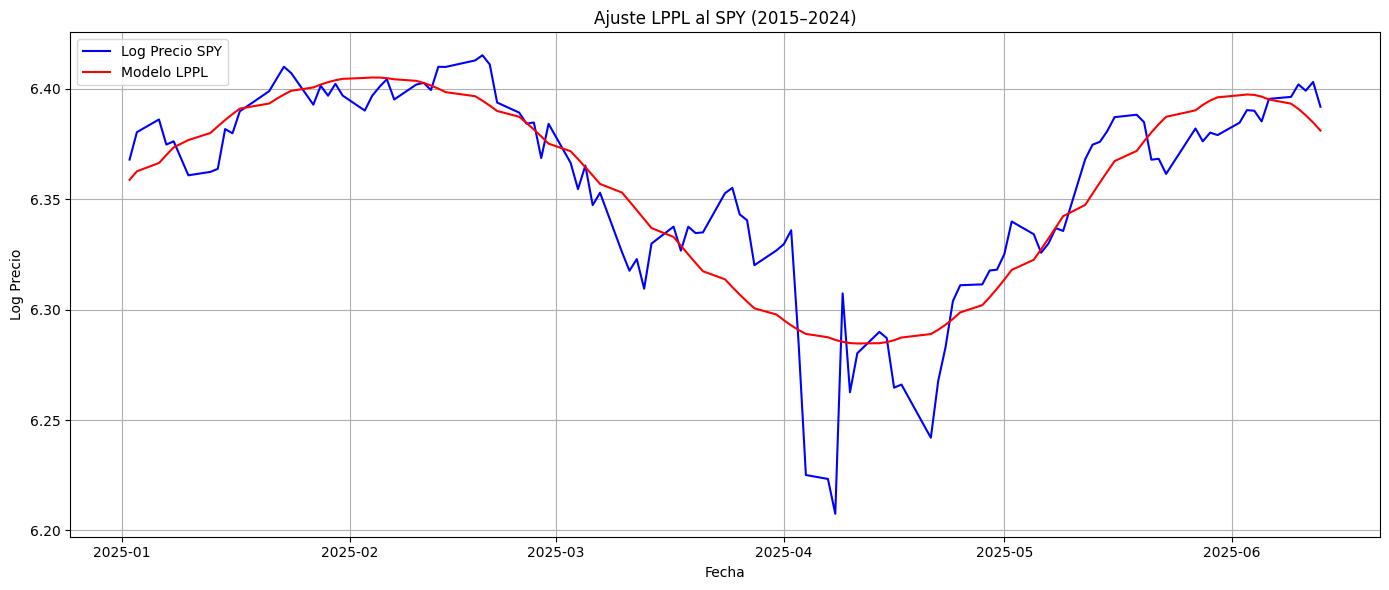

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import curve_fit

# === Función LPPL ===
def lppl(t, A, B, C, tc, m, omega, phi):
    return A + B * (tc - t) ** m + C * (tc - t) ** m * np.cos(omega * np.log(tc - t) - phi)


fecha_inicio = f"{datetime.now().year}-01-01"
fecha_fin = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")


# === Descargar datos del SPY desde 2015 ===
spy = yf.download("SPY", start=fecha_inicio, end=fecha_fin)
spy['LogClose'] = np.log(spy['Close'])
spy = spy.reset_index()
spy['t'] = np.arange(len(spy))  # tiempo discreto

# === Ajustar LPPL al periodo completo ===
t = spy['t'].values
log_price = spy['LogClose'].values

# === Parámetros iniciales ===
tc_init = t[-1] + 50  # fecha crítica 50 días después del último
p0 = [10, -1, 0.1, tc_init, 0.5, 8, 0]

# === Límites de parámetros razonables ===
bounds = ([0, -np.inf, -np.inf, t[-1], 0.01, 6, -np.pi],
          [np.inf, 0, np.inf, t[-1] + 300, 1, 13, np.pi])

# === Ajuste LPPL ===
try:
    popt, _ = curve_fit(lppl, t, log_price, p0=p0, bounds=bounds, maxfev=10000)
    fitted_lppl = lppl(t, *popt)
except RuntimeError:
    print("El ajuste LPPL no convergió.")
    popt = None
    fitted_lppl = None

# === Gráfica ===
plt.figure(figsize=(14, 6))
plt.plot(spy['Date'], log_price, label='Log Precio SPY', color='blue')
if fitted_lppl is not None:
    plt.plot(spy['Date'], fitted_lppl, label='Modelo LPPL', color='red')
plt.title('Ajuste LPPL al SPY (2015–2024)')
plt.xlabel('Fecha')
plt.ylabel('Log Precio')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<ipython-input-6-1369254966>:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=fecha_inicio, end=fecha_fin)
[*********************100%***********************]  1 of 1 completed


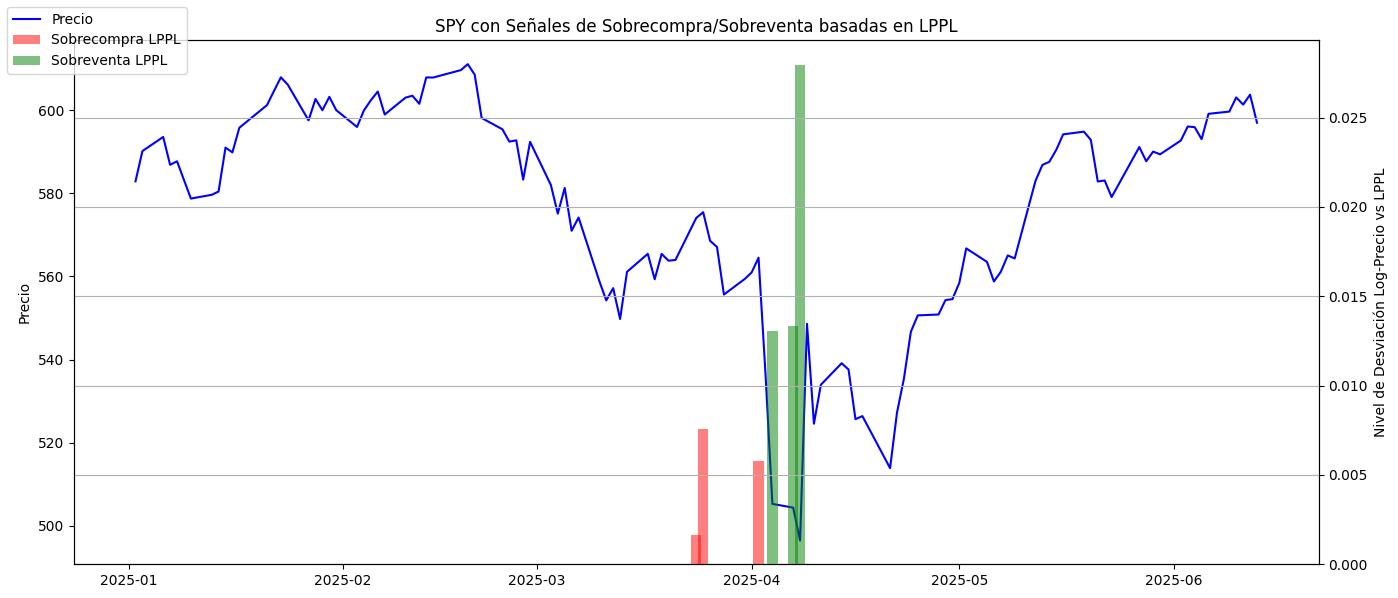

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === Función LPPL ===
def lppl(t, A, B, C, tc, m, omega, phi):
    return A + B * (tc - t) ** m + C * (tc - t) ** m * np.cos(omega * np.log(tc - t) - phi)

# === Descargar datos ===
symbol = "SPY"
data = yf.download(symbol, start=fecha_inicio, end=fecha_fin)
data = data[['Close']]
data = data.reset_index()
data['t'] = np.arange(len(data))
data['LogClose'] = np.log(data['Close'])

# === Ajustar LPPL ===
t = data['t'].values
log_price = data['LogClose'].values

# Parámetros iniciales
tc_init = t[-1] + 30
p0 = [10, -1, 0.1, tc_init, 0.5, 8, 0]
bounds = ([0, -np.inf, -np.inf, t[-1], 0.01, 6, -np.pi],
          [np.inf, 0, np.inf, t[-1] + 200, 1, 13, np.pi])

try:
    popt, _ = curve_fit(lppl, t, log_price, p0=p0, bounds=bounds, maxfev=10000)
    data['LPPL'] = lppl(t, *popt)
    data['Residual'] = data['LogClose'] - data['LPPL']
except RuntimeError:
    print("El ajuste LPPL no convergió.")
    data['LPPL'] = np.nan
    data['Residual'] = np.nan

# === Detectar extremos LPPL (percentiles) ===
q_high = data['Residual'].quantile(0.975)
q_low = data['Residual'].quantile(0.025)

data['Overbought'] = np.where(data['Residual'] > q_high, data['Residual'] - q_high, 0)
data['Oversold'] = np.where(data['Residual'] < q_low, q_low - data['Residual'], 0)

# === Graficar ===
fig, ax1 = plt.subplots(figsize=(14, 6))

# Precio real
ax1.plot(data['Date'], data['Close'], color='blue', label='Precio')
ax1.set_ylabel('Precio')
ax1.set_title(f'{symbol} con Señales de Sobrecompra/Sobreventa basadas en LPPL')

# Segundo eje para extremos
ax2 = ax1.twinx()
ax2.bar(data['Date'], data['Overbought'], width=1.5, color='red', alpha=0.5, label='Sobrecompra LPPL')
ax2.bar(data['Date'], data['Oversold'], width=1.5, color='green', alpha=0.5, label='Sobreventa LPPL')
ax2.set_ylabel('Nivel de Desviación Log-Precio vs LPPL')

# Leyenda y estilo
fig.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()